In [4]:
import numpy as np
import pandas as pd

In [5]:
# reading all the tweets
campaign_tweets = pd.read_csv('archive/Twitter/AbbottCampaign-tweets.csv', usecols=['Publication Year', 'Author', 'Title', 'Publication Title'])
gov_tweets = pd.read_csv('archive/Twitter/GovAbbott-tweets.csv', usecols=['Publication Year', 'Author', 'Title', 'Publication Title'])
abbot_tweets = pd.read_csv('archive/Twitter/GregAbbott_TX-tweets.csv', usecols=['Publication Year', 'Author', 'Title', 'Publication Title'])

In [6]:
campaign_tweets.groupby(['Author']).count()

,Publication Year,Title,Publication Title
Author,,,
Texans for Abbott,4,4,4
Texans for Abbott [@AbbottCampaign],24,24,24


In [7]:
# fixing author so its standard 
mask = abbot_tweets['Author'].str.contains(r'\AGreg Abbott\Z')
abbot_tweets.loc[mask, 'Author'] = abbot_tweets.loc[mask, 'Author'].str.replace('Greg Abbott', 'Greg Abbott [@GregAbbott_TX]')

mask = campaign_tweets['Author'].str.contains(r'\ATexans for Abbott\Z')
campaign_tweets.loc[mask, 'Author'] = campaign_tweets.loc[mask, 'Author'].str.replace('Texans for Abbott', 'Texans for Abbott [@AbbottCampaign]')

In [8]:
campaign_tweets.groupby(['Author']).count()

,Publication Year,Title,Publication Title
Author,,,
Texans for Abbott [@AbbottCampaign],28,28,28


In [9]:
# combine the three lists into one
tweets = pd.concat([abbot_tweets, gov_tweets, campaign_tweets], ignore_index=True)
tweets.groupby(['Author']).count()['Title']

Author
Gov. Greg Abbott [@GovAbbott]          91
Greg Abbott [@GregAbbott_TX]           68
Texans for Abbott [@AbbottCampaign]    28
Name: Title, dtype: int64

In [10]:
tweets[tweets['Publication Year'] == 2021].count()['Title']

38

In [350]:
years = [2021, 2022, 2023]
abbot_dict = {}

for year in years:
    text_year = " ".join(tweets[tweets['Publication Year'] == year]['Title'])
    abbot_dict[year] = text_year.lower()

In [271]:
def rep(s, words):
    for key in words:
        for value in words[key]:
            s = s.replace(value, key)
    return s

In [363]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
import re
from nltk.probability import FreqDist

stop_words = set(stopwords.words('english'))
new_words = {'texas', 'tx', 'operation', 'lone', 'star', 'state', 'said', 'austin', 'greg', 'every', 'accross', 'since', 'lbs',
             'administration', 'it', 'along', 'olivarez', 'also', 'p', 'https', 'co', 'operationlonestar', 'pres', 'continue'}
stop_words = stop_words.union(new_words)

tokenizer = RegexpTokenizer(r'\b[^\d\W]+\b')
# tokenizer = RegexpTokenizer(r'\b(?!https)\w+\b')

pattern = [r'\bfox\snews\b', r'\brio\sgrande\b', r'\bnational\sguard\b']
year_freqs = {}
total_words = []

# define words to replace
words_to_replace = {
    'dps': ['department of public safety', 'txdps', 'txdeptpublicsafety'],
    'abbott': ['gregabbott_tx', 'governor abbott', 'governor'],
    'biden': ['president biden', 'president'],
    'trafficking': ['human trafficking'],
    'lieutenant': ['lt'],
    'continue': ['continues']
}

for year, text in abbot_dict.items():
    
    # replace similar words and phrases together
    t = re.sub(r"http\S+", "", text)
    t = rep(t, words_to_replace)
    
    tokens = tokenizer.tokenize(t)
    new_tokens = []
    
    for i in range(len(tokens)):
        if i < len(tokens)-1 and re.match(pattern[0], tokens[i] + " " + tokens[i+1]):
            new_tokens.append(tokens[i] + " " + tokens[i+1])
        elif i < len(tokens)-1 and re.match(pattern[1], tokens[i] + " " + tokens[i+1]):
            new_tokens.append(tokens[i] + " " + tokens[i+1])
        elif i < len(tokens)-1 and re.match(pattern[2], tokens[i] + " " + tokens[i+1]):
            new_tokens.append(tokens[i] + " " + tokens[i+1])
        else:
            new_tokens.append(tokens[i])
    
    filtered_tokens = [token for token in new_tokens if token not in stop_words]
    total_words.append(len(new_tokens))
    fdist = FreqDist(filtered_tokens)
    year_freqs[year] = fdist
    
    
for k, v in year_freqs.items():
    print(k, ':')
    for word, frequency in v.most_common(10):
        print(f"{word}: {frequency}")
    print()

2021 :
border: 53
dps: 22
secure: 18
guard: 17
biden: 14
illegal: 13
national guard: 12
safe: 12
immigrants: 11
keep: 9

2022 :
border: 147
biden: 87
secure: 48
fentanyl: 45
migrants: 43
communities: 32
dps: 32
doses: 30
seized: 30
criminal: 29

2023 :
border: 39
biden: 26
deadly: 18
abbott: 16
secure: 14
fentanyl: 11
illegal: 10
seized: 10
doses: 10
drugs: 10



In [158]:
import matplotlib.pyplot as plt
import seaborn as sns

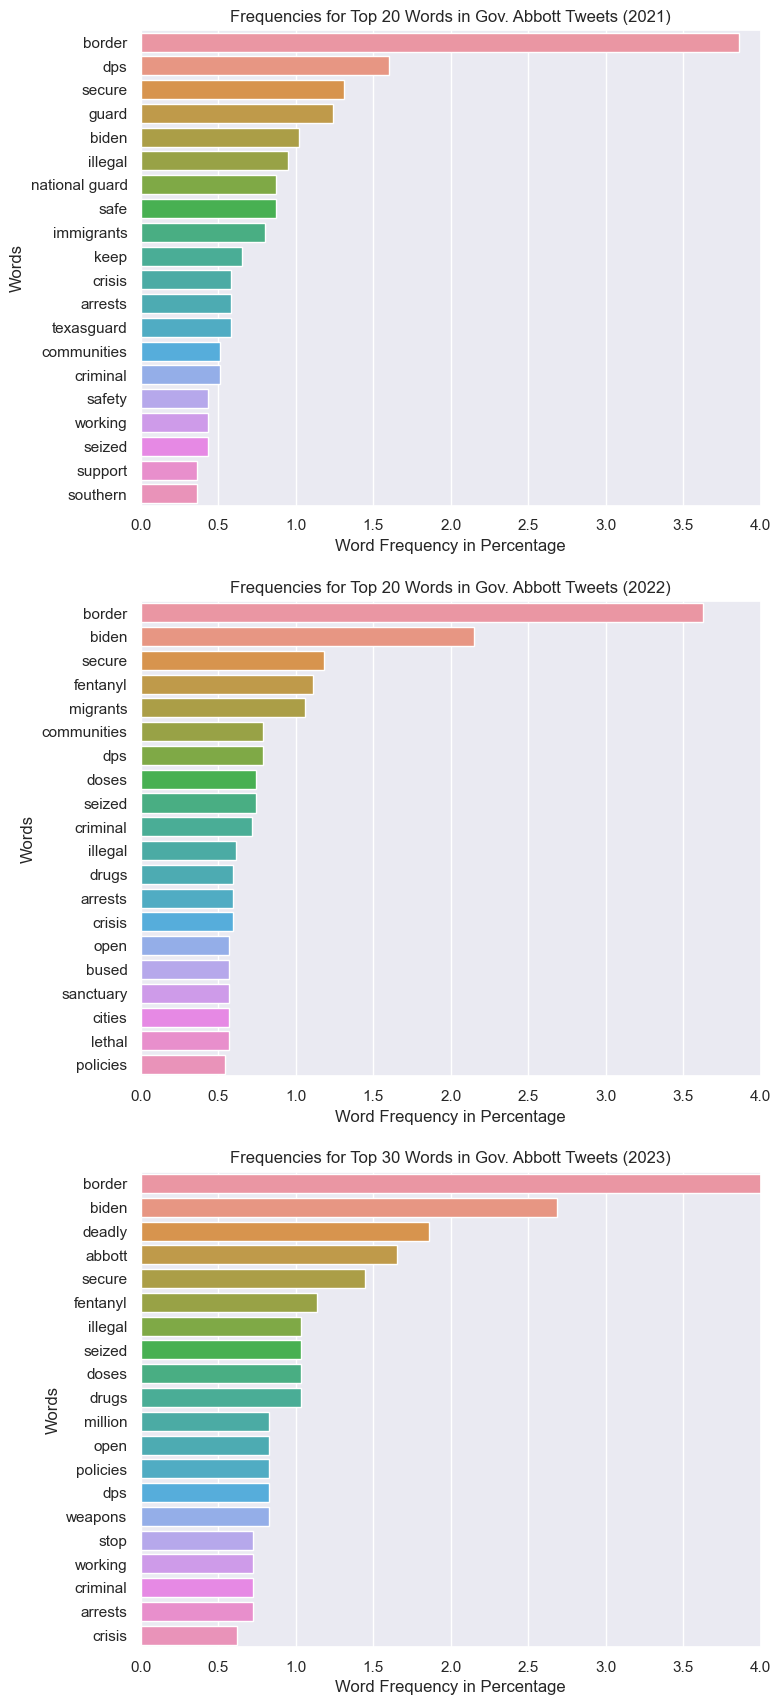

In [364]:
top_words_2021 = [(k ,(v/total_words[0])*100) for k, v in year_freqs[2021].most_common(20)]
top_words_2022 = [(k ,(v/total_words[1])*100) for k, v in year_freqs[2022].most_common(20)]
top_words_2023 = [(k ,(v/total_words[2])*100) for k, v in year_freqs[2023].most_common(20)]


# Create a bar plot of the most common words
fig, axes = plt.subplots(3,1,figsize=(8,21))
sns.set(style="darkgrid")
sns.barplot(ax = axes[0], 
            x=[w[1] for w in top_words_2021], 
            y=[w[0] for w in top_words_2021])
axes[0].set(xlabel='Word Frequency in Percentage',
            ylabel='Words',
            title='Frequencies for Top 20 Words in Gov. Abbott Tweets (2021)')
axes[0].set_xlim(0,4)

sns.barplot(ax = axes[1], 
            x=[w[1] for w in top_words_2022], 
            y=[w[0] for w in top_words_2022])
axes[1].set(xlabel='Word Frequency in Percentage',
            ylabel='Words',
            title='Frequencies for Top 20 Words in Gov. Abbott Tweets (2022)')
axes[1].set_xlim(0,4)

sns.barplot(ax = axes[2], 
            x=[w[1] for w in top_words_2023], 
            y=[w[0] for w in top_words_2023])
axes[2].set(xlabel='Word Frequency in Percentage',
            ylabel='Words',
            title='Frequencies for Top 30 Words in Gov. Abbott Tweets (2023)')
axes[2].set_xlim(0,4)

plt.savefig('images/Tweets/Gov_freqs_years.png', bbox_inches='tight')
plt.show()

In [365]:
all_text = " ".join(tweets['Title']).lower()

all_text = rep(all_text, words_to_replace)

tokens = tokenizer.tokenize(all_text)

new_tokens = []
for i in range(len(tokens)):
    if i < len(tokens)-1 and re.match(pattern[0], tokens[i] + " " + tokens[i+1]):
        new_tokens.append(tokens[i] + " " + tokens[i+1])
    elif i < len(tokens)-1 and re.match(pattern[1], tokens[i] + " " + tokens[i+1]):
        new_tokens.append(tokens[i] + " " + tokens[i+1])
    elif i < len(tokens)-1 and re.match(pattern[2], tokens[i] + " " + tokens[i+1]):
        new_tokens.append(tokens[i] + " " + tokens[i+1])
    else:
        new_tokens.append(tokens[i])

filtered_tokens = [token for token in new_tokens if token not in stop_words]
total_words = len(new_tokens)
fdist = FreqDist(filtered_tokens)
total_freqs = fdist


for word, frequency in total_freqs.most_common(10):
    print(f"{word}: {frequency}")

border: 239
biden: 127
secure: 80
dps: 62
fentanyl: 58
migrants: 50
illegal: 48
seized: 46
criminal: 43
deadly: 42


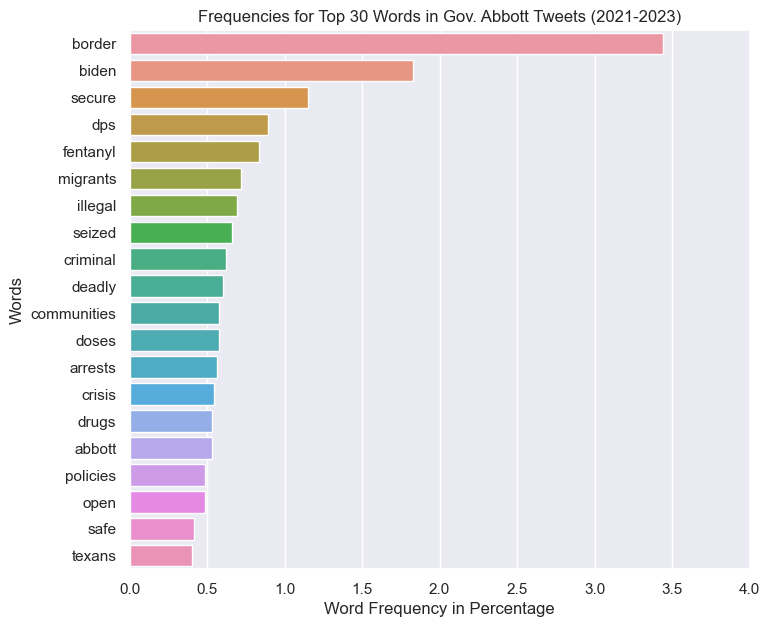

In [366]:
top_words = [(k ,(v/total_words)*100) for k, v in total_freqs.most_common(20)]

# Create a bar plot of the most common words
fig, ax = plt.subplots(1,1,figsize=(8,7))
sns.set(style="darkgrid")
sns.barplot(ax=ax,
            x=[w[1] for w in top_words], 
            y=[w[0] for w in top_words])
ax.set(xlabel='Word Frequency in Percentage',
       ylabel='Words',
       title='Frequencies for Top 30 Words in Gov. Abbott Tweets (2021-2023)')
ax.set_xlim(0,4)

plt.savefig('images/Tweets/Gov_freqs_all.png', bbox_inches='tight')
plt.show()

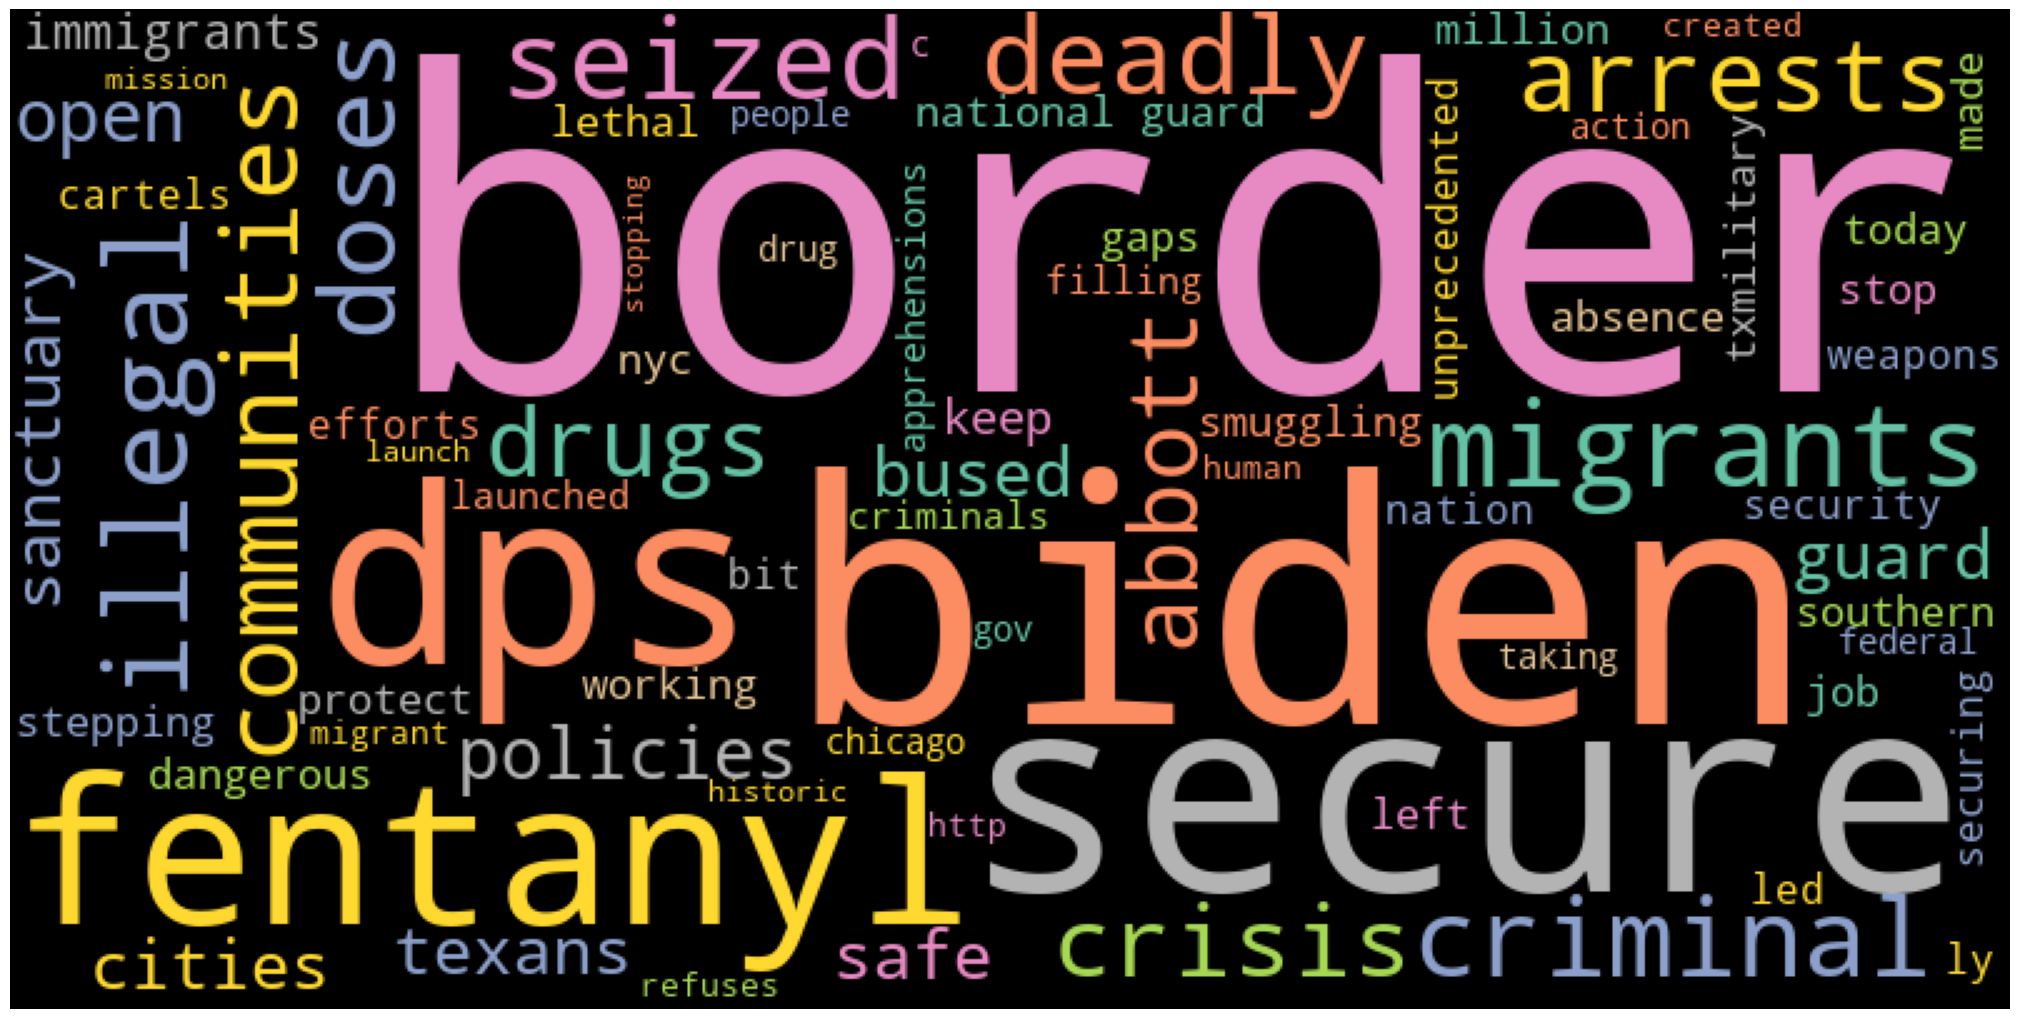

In [367]:
from wordcloud import WordCloud

top_words = total_freqs.most_common(75)
gov_dict = {}
for k, v in top_words:
    gov_dict[k] = v

word_cloud = WordCloud(min_font_size=7, background_color='black', colormap='Set2', width=800, height=400).generate_from_frequencies(gov_dict)

plt.figure(figsize=(20, 10), facecolor=None)
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

plt.savefig('images/Tweets/Gov_word_cloud.png', dpi=500)
plt.show()

In [14]:
import re

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [48]:
# 3-gram analysis
import nltk
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer


stop_words = set(stopwords.words('english'))
new_words = {'operation', 'lone', 'star', 's', 'operationlonestar'}
stop_words = stop_words.union(new_words)

tweets['Title'] = tweets['Title'].apply(remove_urls)

tokenizer = RegexpTokenizer(r'\b[^\d\W]+\b')
trigrams = []

for _, row in tweets.iterrows():
    
    tokens = tokenizer.tokenize(row['Title'].lower())
    filtered_tokens = [token for token in tokens if token not in stop_words]
    tri = ngrams(filtered_tokens, 3)
    trigrams += tri
    
print(trigrams[:10])

[('texas', 'securing', 'southern'), ('securing', 'southern', 'border'), ('southern', 'border', 'keeping'), ('border', 'keeping', 'communities'), ('keeping', 'communities', 'safe'), ('communities', 'safe', 'influx'), ('safe', 'influx', 'illegal'), ('influx', 'illegal', 'drugs'), ('illegal', 'drugs', 'people'), ('drugs', 'people', 'coming')]


In [49]:
from collections import Counter

trigram_freq = Counter(trigrams)
print(trigram_freq.most_common(10))

[(('open', 'border', 'policies'), 33), (('biden', 'open', 'border'), 23), (('texas', 'national', 'guard'), 20), (('migrants', 'sanctuary', 'cities'), 18), (('bused', 'migrants', 'sanctuary'), 15), (('fentanyl', 'doses', 'seized'), 12), (('lethal', 'fentanyl', 'doses'), 12), (('deadly', 'fentanyl', 'doses'), 11), (('doses', 'seized', 'migrants'), 11), (('deadly', 'drugs', 'weapons'), 10)]


In [50]:
print("3-grams for gov. Abbott tweets")
for tri, freq in trigram_freq.most_common(15):
    print(f'{tri}: {freq}')

3-grams for gov. Abbott tweets
('open', 'border', 'policies'): 33
('biden', 'open', 'border'): 23
('texas', 'national', 'guard'): 20
('migrants', 'sanctuary', 'cities'): 18
('bused', 'migrants', 'sanctuary'): 15
('fentanyl', 'doses', 'seized'): 12
('lethal', 'fentanyl', 'doses'): 12
('deadly', 'fentanyl', 'doses'): 11
('doses', 'seized', 'migrants'): 11
('deadly', 'drugs', 'weapons'): 10
('dangerous', 'gaps', 'left'): 10
('gaps', 'left', 'biden'): 10
('seized', 'migrants', 'bused'): 10
('secure', 'border', 'texas'): 9
('made', 'criminal', 'arrests'): 9


In [53]:
df_trigram = pd.DataFrame(list(trigram_freq.items()), columns=['Trigram', 'Frequency'])
df_top15 = df_trigram.sort_values('Frequency', ascending=False).head(15)

print("3-grams for gov. Abbott tweets")
print(df_top15)
df_top15.to_csv('Trigrams/gov_trigrams.csv', index=False)

3-grams for gov. Abbott tweets
                           Trigram  Frequency
207       (open, border, policies)         33
368          (biden, open, border)         23
38        (texas, national, guard)         20
836  (migrants, sanctuary, cities)         18
835   (bused, migrants, sanctuary)         15
967      (lethal, fentanyl, doses)         12
868      (fentanyl, doses, seized)         12
869      (doses, seized, migrants)         11
723      (deadly, fentanyl, doses)         11
870      (seized, migrants, bused)         10
811            (gaps, left, biden)         10
810        (dangerous, gaps, left)         10
751       (deadly, drugs, weapons)         10
948     (filling, dangerous, gaps)          9
290      (made, criminal, arrests)          9


TODO:
- look into quality control: send code to Dr. Lin to ensure that its good

TODO:
- way that a state can request fed funding under an tmd act "drug interdiction and counterdrug activities" -> no request made, not stated in any press release 
- updated table 1 for number of press releases
- send summary of methodology 
- convert formating for graphs - times new roman, 03/21 -> Mar 21
- graph for abbotts top 10 word frequencies compared with DPS top 10 -> Figure 4 -- do for Press Releases and Tweets
- Change color of Press Release word clouds to Black Set 2 colors, also set higher resolution
- n-grams turn into a table
- table 2 for count of number of posts- create graph comparing all of them 

## DPS Tweets

In [29]:
dps_tweets = pd.read_csv('archive/Twitter/TxDPS-tweets.csv', usecols=['Publication Year', 'Author', 'Title', 'Publication Title'])

In [30]:
dps_tweets.head()

,Publication Year,Author,Title,Publication Title
0,2022,Texas DPS,Courtesy | Service | Protection Whether workin...,@TxDPS
1,2022,Texas DPS,As part of our mission under Gov. @GregAbbott_...,@TxDPS
2,2022,Texas DPS,DPS Aircraft play a vital role in supporting t...,@TxDPS
3,2022,Texas DPS,DPS continues to step up to the plate as part ...,@TxDPS
4,2022,Texas DPS,ICYMI: DPS & TMD Stop Large Migrant Groups in ...,@TxDPS


In [369]:
years = [2021, 2022, 2023]
dps_dict = {}

for year in years:
    dps_year = " ".join(dps_tweets[dps_tweets['Publication Year'] == year]['Title'])
    dps_dict[year] = dps_year.lower()

In [372]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
import re
from nltk.probability import FreqDist

stop_words = set(stopwords.words('english'))
new_words = {'texas', 'tx', 'operation', 'lone', 'star', 'us', 'ols', 'said', 'state', 'pdf', 'adobe', 'reader', 'one',
            'two', 'u', 'https', 'co', 'operationlonestar', 'abbottabbott', 'keep', 'continue', 'made', 'day'}
stop_words = stop_words.union(new_words)

tokenizer = RegexpTokenizer(r'\b[^\d\W]+\b')

pattern = [r'\bopen\sborder\b']
dps_freqs = {}
total_words = []

# define words to replace
words_to_replace = {
    'dps': ['department of public safety', 'txdps', 'txdeptpublicsafety'],
    'request': ['requests'],
    'abbott': ['gregabbott_tx', 'govabbott', 'governor abbott', 'governor'],
    'biden': ['president'],
    'continue': ['continues']
}

for year, text in dps_dict.items():
    
    # replace similar words and phrases together
    t = re.sub(r"http\S+", "", text)
    t = rep(t, words_to_replace)
    
    tokens = tokenizer.tokenize(t)
    new_tokens = []
    
    for i in range(len(tokens)):
        if i < len(tokens)-1 and re.match(pattern[0], tokens[i] + " " + tokens[i+1]):
            new_tokens.append(tokens[i] + " " + tokens[i+1])
        else:
            new_tokens.append(tokens[i])
    
    filtered_tokens = [token for token in new_tokens if token not in stop_words]
    total_words.append(len(new_tokens))
    fdist = FreqDist(filtered_tokens)
    dps_freqs[year] = fdist
    
    
for k, v in dps_freqs.items():
    print(k, ':')
    for word, frequency in v.most_common(10):
        print(f"{word}: {frequency}")
    print()

2021 :
dps: 101
abbott: 84
border: 62
gov: 46
secure: 26
part: 24
troopers: 22
drugs: 20
work: 20
briefing: 19

2022 :
dps: 58
abbott: 57
border: 47
gov: 42
secure: 27
part: 23
working: 21
mission: 20
protect: 19
drugs: 18

2023 :
abbott: 2
dps: 1
seized: 1
million: 1
lethal: 1
doses: 1
fentanyl: 1
since: 1
launched: 1
onepillkills: 1



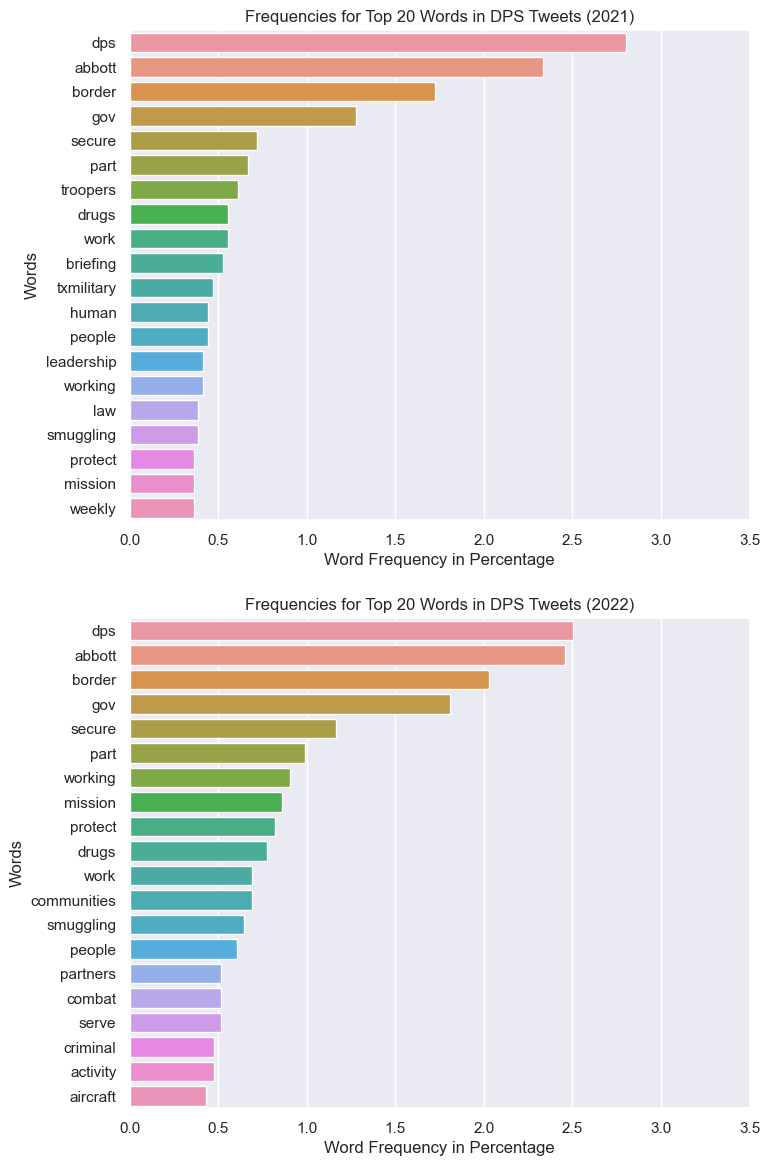

In [373]:
dps_words_2021 = [(k ,(v/total_words[0])*100) for k, v in dps_freqs[2021].most_common(20)]
dps_words_2022 = [(k ,(v/total_words[1])*100) for k, v in dps_freqs[2022].most_common(20)]
dps_words_2023 = [(k ,(v/total_words[2])*100) for k, v in dps_freqs[2023].most_common(20)]


# Create a bar plot of the most common words
fig, axes = plt.subplots(2,1,figsize=(8,14))
sns.set(style="darkgrid")
sns.barplot(ax = axes[0], 
            x=[w[1] for w in dps_words_2021], 
            y=[w[0] for w in dps_words_2021])
axes[0].set(xlabel='Word Frequency in Percentage',
            ylabel='Words',
            title='Frequencies for Top 20 Words in DPS Tweets (2021)')
axes[0].set_xlim(0,3.5)

sns.barplot(ax = axes[1], 
            x=[w[1] for w in dps_words_2022], 
            y=[w[0] for w in dps_words_2022])
axes[1].set(xlabel='Word Frequency in Percentage',
            ylabel='Words',
            title='Frequencies for Top 20 Words in DPS Tweets (2022)')
axes[1].set_xlim(0,3.5)

# sns.barplot(ax = axes[2], 
#             x=[w[1] for w in dps_words_2023], 
#             y=[w[0] for w in dps_words_2023])
# axes[2].set(xlabel='Word Frequency in Percentage',
#             ylabel='Words',
#             title='Frequencies for Top 30 Words in DPS Tweets (2023)')
# axes[2].set_xlim(0,4)

plt.savefig('images/Tweets/DPS_freqs_years.png', bbox_inches='tight')
plt.show()

In [374]:
dps_all_text = " ".join(dps_tweets['Title']).lower()

dps_all_text = re.sub(r"http\S+", "", dps_all_text)
dps_all_text = rep(dps_all_text, words_to_replace)

tokens = tokenizer.tokenize(dps_all_text)

new_tokens = []
for i in range(len(tokens)):
    if i < len(tokens)-1 and re.match(pattern[0], tokens[i] + " " + tokens[i+1]):
        new_tokens.append(tokens[i] + " " + tokens[i+1])
    else:
        new_tokens.append(tokens[i])

filtered_tokens = [token for token in new_tokens if token not in stop_words]
total_words = len(new_tokens)
fdist = FreqDist(filtered_tokens)
dps_total_freqs = fdist


for word, frequency in dps_total_freqs.most_common(10):
    print(f"{word}: {frequency}")

dps: 160
abbott: 143
border: 109
gov: 88
secure: 53
part: 47
drugs: 38
working: 36
work: 36
mission: 33


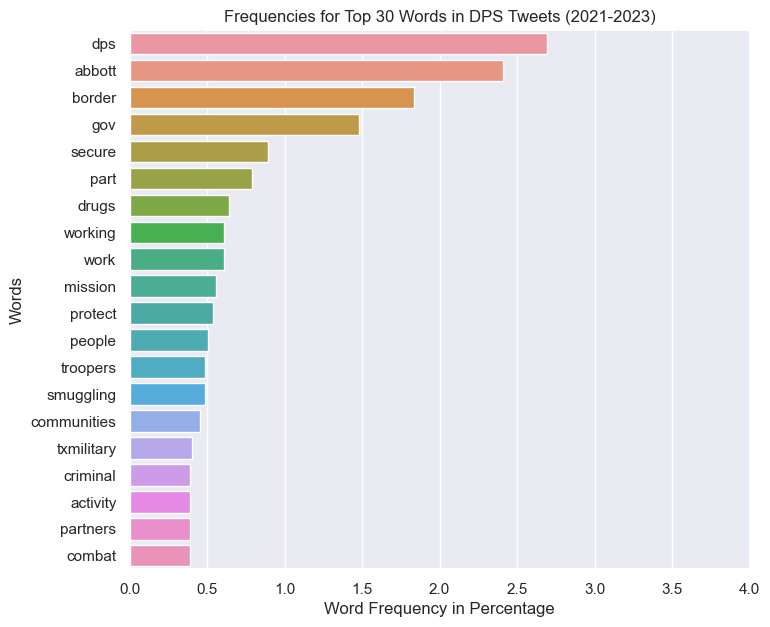

In [375]:
dps_top_words = [(k ,(v/total_words)*100) for k, v in dps_total_freqs.most_common(20)]

# Create a bar plot of the most common words
fig, ax = plt.subplots(1,1,figsize=(8,7))
sns.set(style="darkgrid")
sns.barplot(ax=ax,
            x=[w[1] for w in dps_top_words], 
            y=[w[0] for w in dps_top_words])
ax.set(xlabel='Word Frequency in Percentage',
       ylabel='Words',
       title='Frequencies for Top 30 Words in DPS Tweets (2021-2023)')
ax.set_xlim(0,4)

plt.savefig('images/Tweets/DPS_freqs_all.png', bbox_inches='tight')
plt.show()

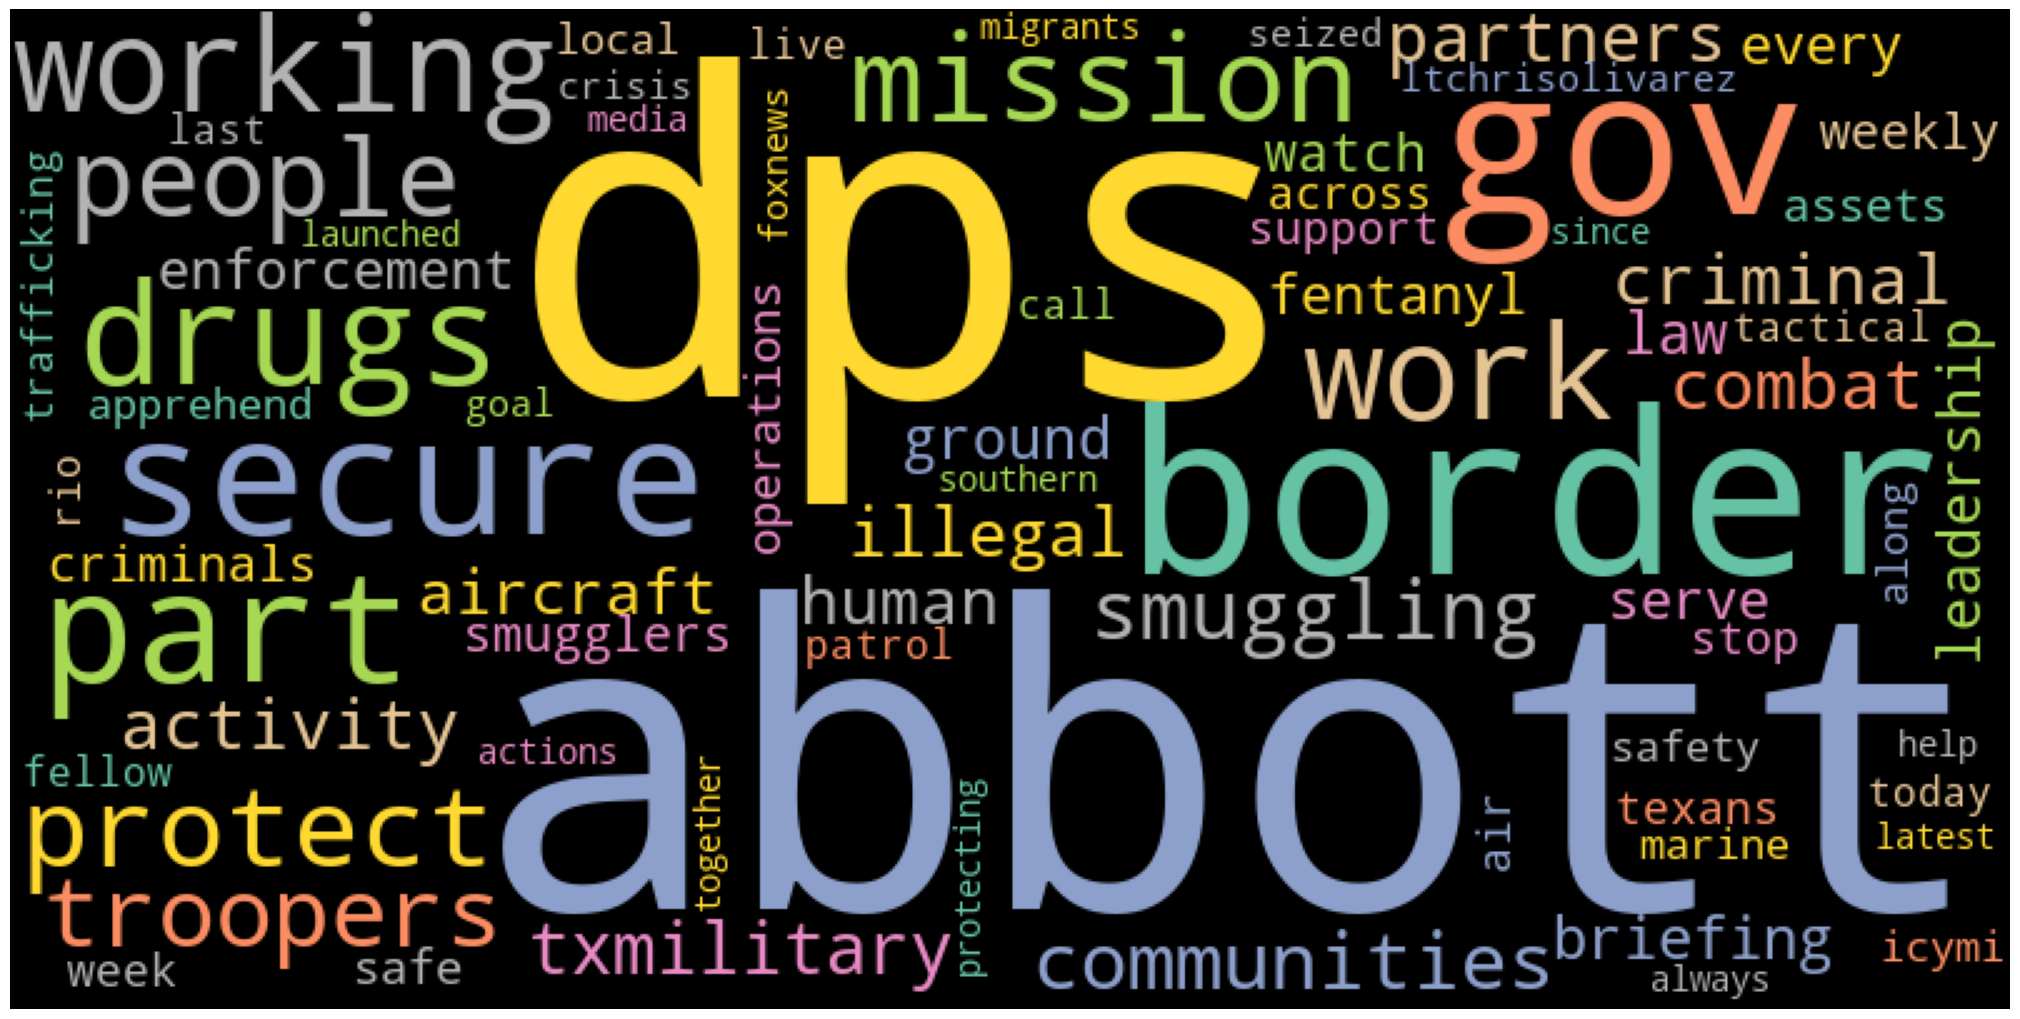

In [376]:
from wordcloud import WordCloud

dps_top_words = dps_total_freqs.most_common(75)
dps_dict = {}
for k, v in dps_top_words:
    dps_dict[k] = v

word_cloud = WordCloud(min_font_size=5, background_color='black', colormap='Set2', width=800, height=400).generate_from_frequencies(dps_dict)

plt.figure(figsize=(20, 10), facecolor=None)
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

plt.savefig('images/Tweets/DPS_word_cloud.png', dpi=500)
plt.show()

In [57]:
# 3-gram analysis
import nltk
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer


stop_words = set(stopwords.words('english'))
new_words = {'operation', 'lone', 'star', 's', 'operationlonestar', 'gregabbott_tx'}
stop_words = stop_words.union(new_words)

dps_tweets['Title'] = dps_tweets['Title'].apply(remove_urls)


tokenizer = RegexpTokenizer(r'\b[^\d\W]+\b')
dps_trigrams = []

for _, row in dps_tweets.iterrows():
    
    tokens = tokenizer.tokenize(row['Title'].lower())
    filtered_tokens = [token for token in tokens if token not in stop_words]
    tri = ngrams(filtered_tokens, 3)
    dps_trigrams += tri
    
print(dps_trigrams[:10])

[('courtesy', 'service', 'protection'), ('service', 'protection', 'whether'), ('protection', 'whether', 'working'), ('whether', 'working', 'border'), ('working', 'border', 'part'), ('border', 'part', 'gov'), ('part', 'gov', 'patrolling'), ('gov', 'patrolling', 'roadways'), ('patrolling', 'roadways', 'spring'), ('roadways', 'spring', 'break')]


In [58]:
from collections import Counter

dps_trigram_freq = Counter(dps_trigrams)
print(dps_trigram_freq.most_common(10))

[(('smuggling', 'people', 'drugs'), 14), (('people', 'drugs', 'texas'), 10), (('combat', 'smuggling', 'people'), 10), (('dps', 'continues', 'work'), 8), (('border', 'part', 'gov'), 7), (('law', 'enforcement', 'partners'), 7), (('every', 'day', 'dps'), 7), (('secure', 'border', 'gov'), 7), (('secure', 'border', 'protect'), 7), (('work', 'secure', 'border'), 7)]


In [59]:
df_dps_trigram = pd.DataFrame(list(dps_trigram_freq.items()), columns=['Trigram', 'Frequency'])
dps_top15 = df_dps_trigram.sort_values('Frequency', ascending=False).head(15)

print("3-grams for DPS tweets")
print(dps_top15)
dps_top15.to_csv('images/Tweets/dps_trigrams.csv', index=False)

3-grams for DPS tweets
                            Trigram  Frequency
116      (smuggling, people, drugs)         14
117          (people, drugs, texas)         10
410     (combat, smuggling, people)         10
422          (dps, continues, work)          8
567          (work, secure, border)          7
482       (secure, border, protect)          7
131               (every, day, dps)          7
45     (law, enforcement, partners)          7
440           (secure, border, gov)          7
5               (border, part, gov)          7
235       (local, law, enforcement)          6
108          (secure, border, part)          6
515           (air, ground, marine)          6
516      (ground, marine, tactical)          5
138  (criminals, combat, smuggling)          5


## TMD Tweets

In [61]:
tmd_tweets = pd.read_csv('archive/Twitter/TxMilitary-tweets.csv', usecols=['Publication Year', 'Author', 'Title', 'Publication Title'])

In [62]:
tmd_tweets.head()

,Publication Year,Author,Title,Publication Title
0,2022,Texas Military Dept.,Members of the #OperationLoneStar Elite Brush ...,@TXMilitary
1,2022,Texas Military Dept. [@TXMilitary],The Texas Guard continues to work with the @Tx...,Twitter
2,2022,Texas Military Dept. [@TXMilitary],#Texas #NationalGuard Members Mobilized in Sup...,Twitter
3,2022,Texas Military Dept. [@TXMilitary],"Why We’re Here – #OperationLoneStar ""We're try...",Twitter
4,2022,Texas Military Dept. [@TXMilitary],Working side-by-side with the @TxDPS on #Opera...,Twitter


In [63]:
mask = tmd_tweets['Author'].str.contains(r'\ATexas Military Dept.\Z')
tmd_tweets.loc[mask, 'Author'] = tmd_tweets.loc[mask, 'Author'].str.replace('Texas Military Dept.', 'Texas Military Dept. [@TXMilitary]', regex=True)

In [64]:
tmd_tweets.groupby('Author').count()

,Publication Year,Title,Publication Title
Author,,,
Texas Military Dept. [@TXMilitary],53,53,53


In [383]:
years = [2021, 2022, 2023]
tmd_dict = {}

for year in years:
    tmd_year = " ".join(tmd_tweets[tmd_tweets['Publication Year'] == year]['Title'])
    tmd_dict[year] = tmd_year.lower()

In [60]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
import re
from nltk.probability import FreqDist

stop_words = set(stopwords.words('english'))
new_words = {'texas', 'operation', 'lone', 'star', 'us', 'austin', 'https', 'co', 'operationlonestar', 'abbottabbott',
            'keep', 'made', 'along', 'gregabbott_texas', 'members', 'grande', 'side'}
stop_words = stop_words.union(new_words)

tokenizer = RegexpTokenizer(r'\b[^\d\W]+\b')

pattern = [r'\btexas\smilitary\sdepartment\b', r'\barmy\snational\sguard\b', r'\bnational\sguard\b', 
           r'\department\sof\spublic\ssafety\b', r'\btexas\sair\snational\sguard\b', r'\bair\snational\sguard\b',
           r'\btexas\sstate\sguard\b', r'\brio\sgrande\b']
tmd_freqs = {}
total_words = []

# define words to replace
words_to_replace = {
    'dps': ['department of public safety', 'txdps', 'txdeptpublicsafety'],
    'abbott': ['governor abbott', 'governor', 'gov'],
    'biden': ['president', 'pres'],
    'tmd': ['texas military department'],
    'national guard': ['txng', 'texas national guard', 'txarng', 'army national guard', 'txang', 'texas army national guard'],
    'state guard': ['txsg', 'texas state guard'],
    'continue': ['continues'],
    'trafficking': ['human trafficking'],
    'texas': ['tx'],
    'rio grande': ['rio grande river', 'river']
}

for year, text in tmd_dict.items():
    
    # replace similar words and phrases together
    t = re.sub(r"http\S+", "", text)
    t = rep(t, words_to_replace)
    
    words = tokenizer.tokenize(t)
    new_tokens = []
    
    for i in range(len(words)):
        if i < len(words)-2 and re.match(pattern[0], words[i] + " " + words[i+1]+ " " + words[i+2]):
            new_tokens.append(words[i] + " " + words[i+1] + " " + words[i+2])
        elif i < len(words)-2 and re.match(pattern[1], words[i] + " " + words[i+1]+ " " + words[i+2]):
            new_tokens.append(words[i] + " " + words[i+1] + " " + words[i+2])
        elif i < len(words)-1 and re.match(pattern[2], words[i] + " " + words[i+1]):
            new_tokens.append(words[i] + " " + words[i+1])
        elif i < len(words)-3 and re.match(pattern[3], words[i] + " " + words[i+1] + " " + words[i+2]+ " " + words[i+3]):
            new_tokens.append(words[i] + " " + words[i+1] + " " + words[i+2] + " " + words[i+3])
        elif i < len(words)-3 and re.match(pattern[4], words[i] + " " + words[i+1] + " " + words[i+2]+ " " + words[i+3]):
            new_tokens.append(words[i] + " " + words[i+1] + " " + words[i+2] + " " + words[i+3])
        elif i < len(words)-2 and re.match(pattern[5], words[i] + " " + words[i+1]+ " " + words[i+2]):
            new_tokens.append(words[i] + " " + words[i+1] + " " + words[i+2])
        elif i < len(words)-2 and re.match(pattern[6], words[i] + " " + words[i+1]+ " " + words[i+2]):
            new_tokens.append(words[i] + " " + words[i+1] + " " + words[i+2])
        elif i < len(words)-1 and re.match(pattern[7], words[i] + " " + words[i+1]):
            new_tokens.append(words[i] + " " + words[i+1])
        else:
            new_tokens.append(words[i])
    
    filtered_tokens = [token for token in new_tokens if token not in stop_words]
    total_words.append(len(new_tokens))
    fdist = FreqDist(filtered_tokens)
    tmd_freqs[year] = fdist
    
    
for k, v in tmd_freqs.items():
    print(k, ':')
    for word, frequency in v.most_common(10):
        print(f"{word}: {frequency}")
    print()

NameError: name 'tmd_dict' is not defined

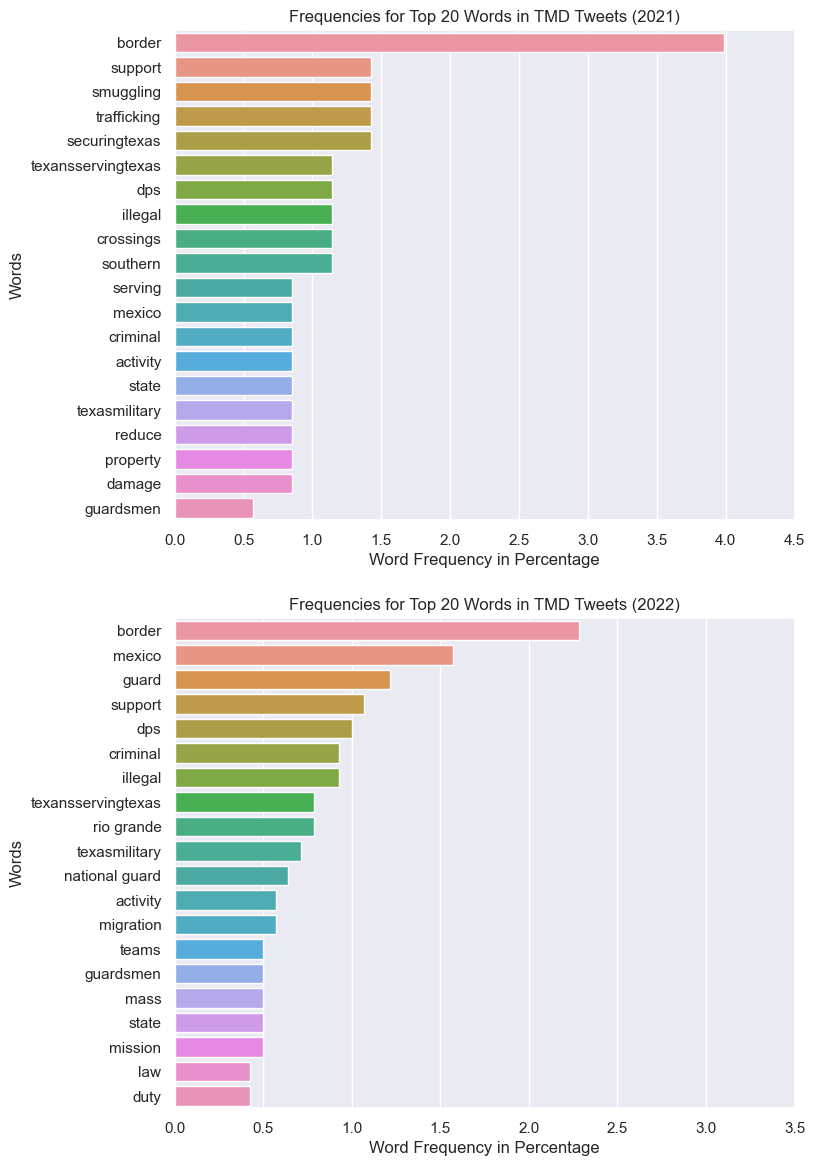

In [386]:
tmd_words_2021 = [(k ,(v/total_words[0])*100) for k, v in tmd_freqs[2021].most_common(20)]
tmd_words_2022 = [(k ,(v/total_words[1])*100) for k, v in tmd_freqs[2022].most_common(20)]


# Create a bar plot of the most common words
fig, axes = plt.subplots(2,1,figsize=(8,14))
sns.set(style="darkgrid")
sns.barplot(ax = axes[0], 
            x=[w[1] for w in tmd_words_2021], 
            y=[w[0] for w in tmd_words_2021])
axes[0].set(xlabel='Word Frequency in Percentage',
            ylabel='Words',
            title='Frequencies for Top 20 Words in TMD Tweets (2021)')
axes[0].set_xlim(0,4.5)

sns.barplot(ax = axes[1], 
            x=[w[1] for w in tmd_words_2022], 
            y=[w[0] for w in tmd_words_2022])
axes[1].set(xlabel='Word Frequency in Percentage',
            ylabel='Words',
            title='Frequencies for Top 20 Words in TMD Tweets (2022)')
axes[1].set_xlim(0,3.5)

plt.savefig('images/Tweets/TMD_freqs_years.png', bbox_inches='tight')
plt.show()

In [387]:
tmd_all_text = " ".join(tmd_tweets['Title']).lower()

tmd_all_text = re.sub(r"http\S+", "", tmd_all_text)
tmd_all_text = rep(tmd_all_text, words_to_replace)

words = tokenizer.tokenize(tmd_all_text)

new_tokens = []
for i in range(len(words)):
        if i < len(words)-2 and re.match(pattern[0], words[i] + " " + words[i+1]+ " " + words[i+2]):
            new_tokens.append(words[i] + " " + words[i+1] + " " + words[i+2])
        elif i < len(words)-2 and re.match(pattern[1], words[i] + " " + words[i+1]+ " " + words[i+2]):
            new_tokens.append(words[i] + " " + words[i+1] + " " + words[i+2])
        elif i < len(words)-1 and re.match(pattern[2], words[i] + " " + words[i+1]):
            new_tokens.append(words[i] + " " + words[i+1])
        elif i < len(words)-3 and re.match(pattern[3], words[i] + " " + words[i+1] + " " + words[i+2]+ " " + words[i+3]):
            new_tokens.append(words[i] + " " + words[i+1] + " " + words[i+2] + " " + words[i+3])
        elif i < len(words)-3 and re.match(pattern[4], words[i] + " " + words[i+1] + " " + words[i+2]+ " " + words[i+3]):
            new_tokens.append(words[i] + " " + words[i+1] + " " + words[i+2] + " " + words[i+3])
        elif i < len(words)-2 and re.match(pattern[5], words[i] + " " + words[i+1]+ " " + words[i+2]):
            new_tokens.append(words[i] + " " + words[i+1] + " " + words[i+2])
        elif i < len(words)-2 and re.match(pattern[6], words[i] + " " + words[i+1]+ " " + words[i+2]):
            new_tokens.append(words[i] + " " + words[i+1] + " " + words[i+2])
        elif i < len(words)-1 and re.match(pattern[7], words[i] + " " + words[i+1]):
            new_tokens.append(words[i] + " " + words[i+1])
        else:
            new_tokens.append(words[i])
filtered_tokens = [token for token in new_tokens if token not in stop_words]
total_words = len(new_tokens)
fdist = FreqDist(filtered_tokens)
tmd_total_freqs = fdist


for word, frequency in tmd_total_freqs.most_common(20):
    print(f"{word}: {frequency}")

border: 46
mexico: 25
support: 20
guard: 19
dps: 18
illegal: 17
criminal: 16
texansservingtexas: 15
texasmilitary: 13
activity: 11
rio grande: 11
national guard: 10
state: 10
guardsmen: 9
mission: 9
southern: 8
trafficking: 8
crossings: 8
migration: 8
teams: 7


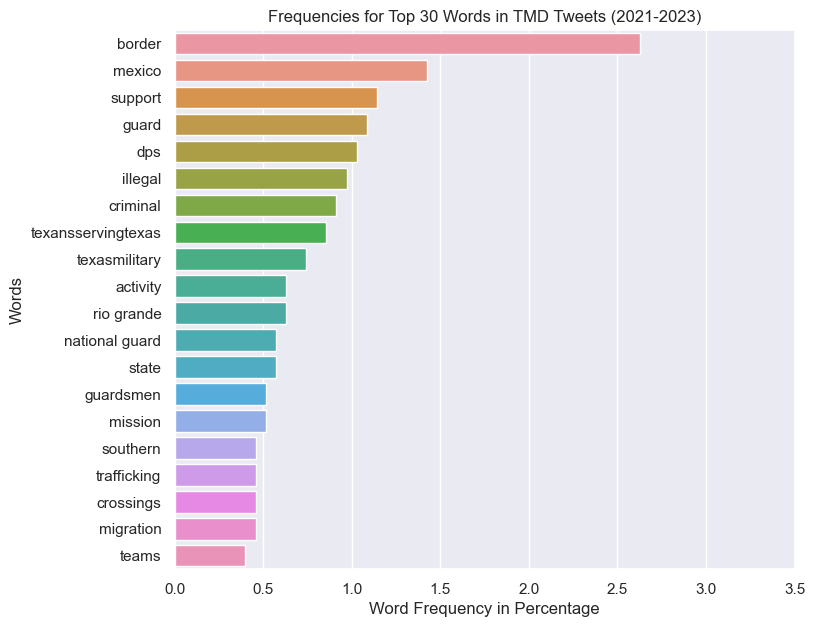

In [388]:
tmd_top_words = [(k ,(v/total_words)*100) for k, v in tmd_total_freqs.most_common(20)]

# Create a bar plot of the most common words
fig, ax = plt.subplots(1,1,figsize=(8,7))
sns.set(style="darkgrid")
sns.barplot(ax=ax,
            x=[w[1] for w in tmd_top_words], 
            y=[w[0] for w in tmd_top_words])
ax.set(xlabel='Word Frequency in Percentage',
       ylabel='Words',
       title='Frequencies for Top 30 Words in TMD Tweets (2021-2023)')
ax.set_xlim(0,3.5)

plt.savefig('images/Tweets/TMD_freqs_all.png', bbox_inches='tight')
plt.show()

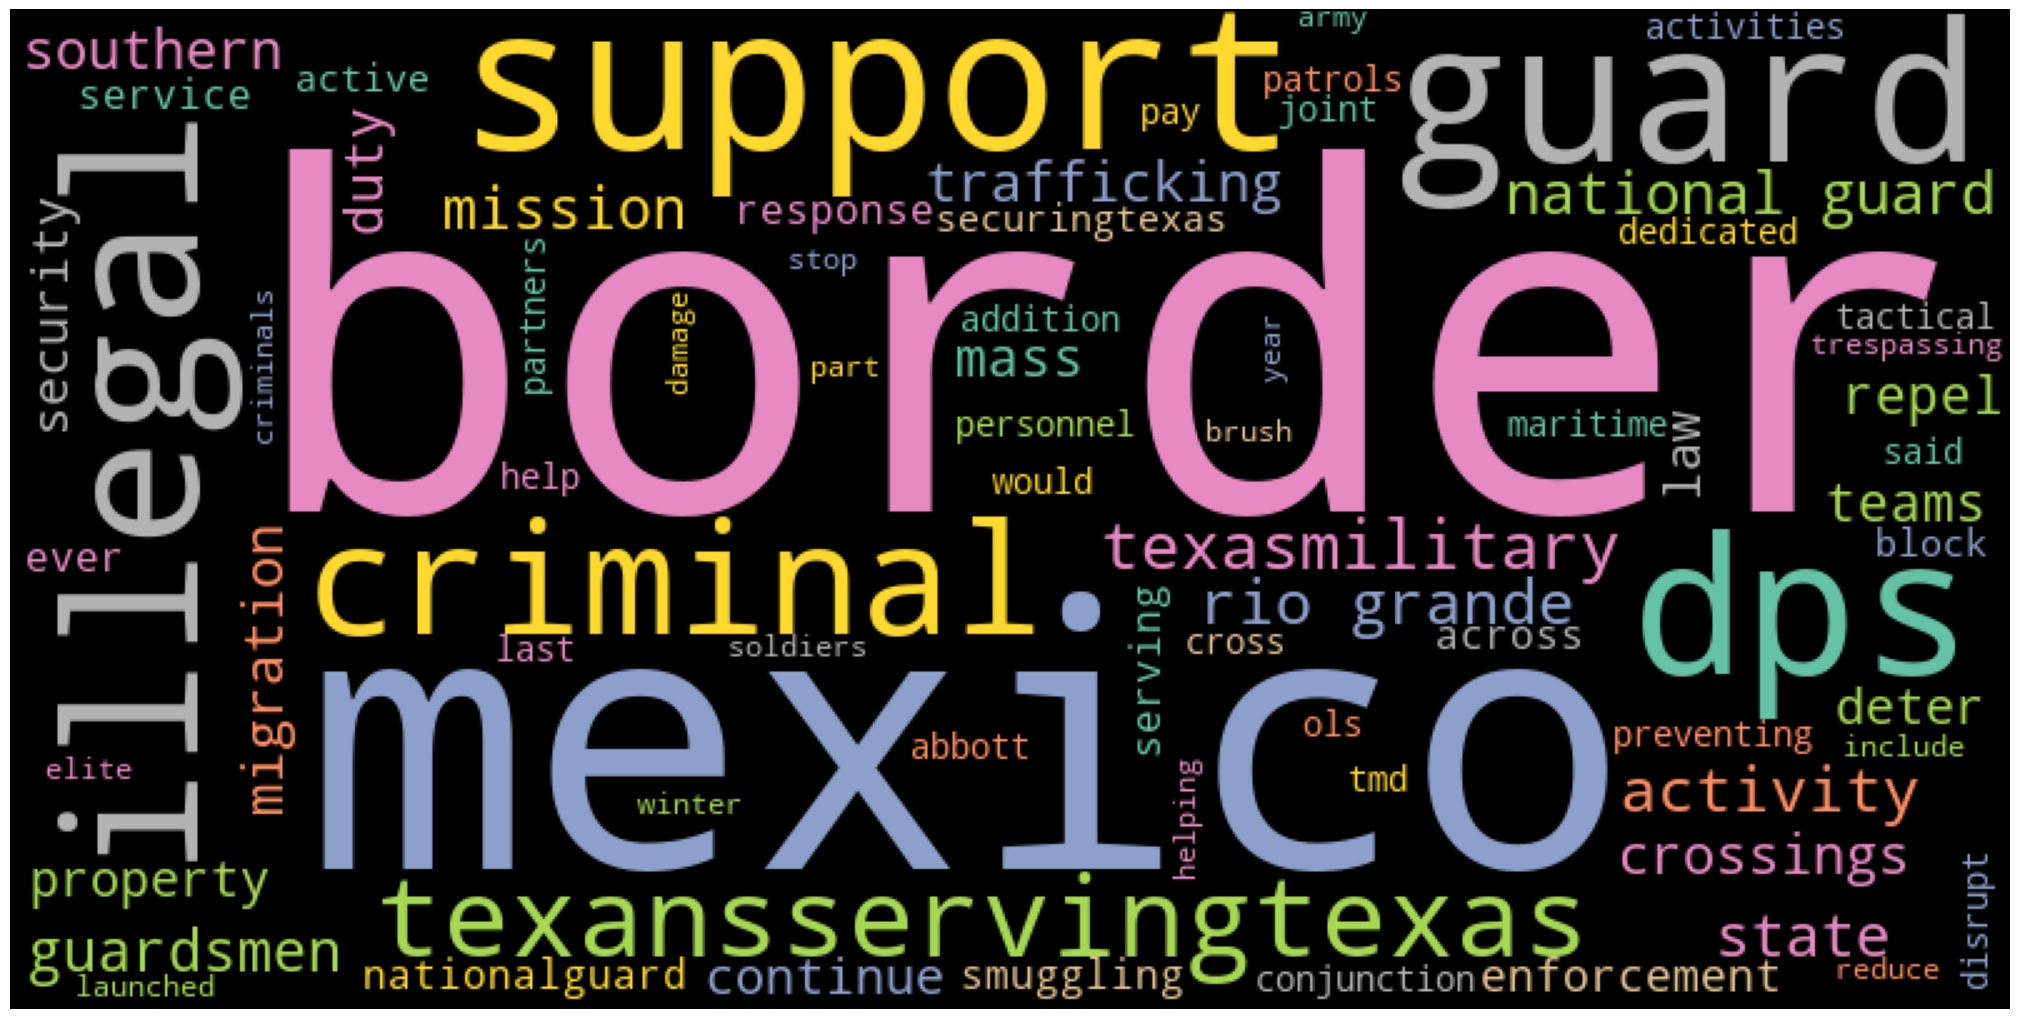

In [390]:
from wordcloud import WordCloud

tmd_top_words = tmd_total_freqs.most_common(75)
tmd_dict = {}
for k, v in tmd_top_words:
    tmd_dict[k] = v

word_cloud = WordCloud(min_font_size=5, background_color='black', colormap='Set2', width=800, height=400).generate_from_frequencies(tmd_dict)

plt.figure(figsize=(20, 10), facecolor=None)
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

plt.savefig('images/Tweets/TMD_word_cloud.png', dpi=500)
plt.show()

In [67]:
# 3-gram analysis
import nltk
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer


stop_words = set(stopwords.words('english'))
new_words = {'operation', 'lone', 'star', 's', 'operationlonestar', 'gregabbott_tx'}
stop_words = stop_words.union(new_words)

tmd_tweets['Title'] = tmd_tweets['Title'].apply(remove_urls)


tokenizer = RegexpTokenizer(r'\b[^\d\W]+\b')
tmd_trigrams = []

for _, row in tmd_tweets.iterrows():
    
    tokens = tokenizer.tokenize(row['Title'].lower())
    filtered_tokens = [token for token in tokens if token not in stop_words]
    tri = ngrams(filtered_tokens, 3)
    tmd_trigrams += tri
    
print(tmd_trigrams[:10])

[('members', 'elite', 'brush'), ('elite', 'brush', 'teams'), ('brush', 'teams', 'arrest'), ('teams', 'arrest', 'suspected'), ('arrest', 'suspected', 'criminals'), ('suspected', 'criminals', 'trespassing'), ('criminals', 'trespassing', 'private'), ('trespassing', 'private', 'property'), ('private', 'property', 'near'), ('property', 'near', 'texas')]


In [69]:
from collections import Counter

tmd_trigram_freq = Counter(tmd_trigrams)
print(tmd_trigram_freq.most_common(10))

[(('texas', 'mexico', 'border'), 21), (('along', 'texas', 'mexico'), 18), (('rio', 'grande', 'river'), 7), (('texas', 'national', 'guard'), 6), (('along', 'southern', 'border'), 5), (('state', 'active', 'duty'), 5), (('active', 'duty', 'mission'), 5), (('smuggling', 'human', 'trafficking'), 4), (('illegal', 'border', 'crossings'), 4), (('criminal', 'activity', 'along'), 4)]


In [72]:
df_tmd_trigram = pd.DataFrame(list(tmd_trigram_freq.items()), columns=['Trigram', 'Frequency'])
tmd_top15 = df_tmd_trigram.sort_values('Frequency', ascending=False).head(15)

print("3-grams for DPS tweets")
print(tmd_top15)
tmd_top15.to_csv('Trigrams/tmd_trigrams.csv', index=False)

3-grams for DPS tweets
                             Trigram  Frequency
11           (texas, mexico, border)         21
99            (along, texas, mexico)         18
588             (rio, grande, river)          7
488         (texas, national, guard)          6
212          (active, duty, mission)          5
211            (state, active, duty)          5
28         (along, southern, border)          5
576          (mission, block, repel)          4
575           (duty, mission, block)          4
580       (activities, along, texas)          4
579    (criminal, activities, along)          4
578    (repel, criminal, activities)          4
577         (block, repel, criminal)          4
152  (smuggling, human, trafficking)          4
587             (along, rio, grande)          4
